# A/B Testing on New UI

## 0. Summary

Based on regression analysis, the results showed that users with the new UI spent 24.29 minutes more compared to the control group and the treatment effect was statistically significant. As seen in the graph below, however, the treatment effect decreased over time. The treatment effect varied when segmented by gender and user type: (1) female users in the treatment group spent 21.1 minutes on average which is 24.9% higher than control group and (2) non-readers who saw the new UI spent 68.8% more time on the new UI compared to the control group. However, the results for 

Since users with higher average time spent were assigned more to treatment group, I used propensity score matching to solve the imbalance. As a result of matching, 46,633 units were matched and the analysis based on matched data showed that control group (baseline: female, contributors) spent 41.0 minutes on average whereas treatment group spent 2.7 minutes more than the control group. The treatment effect was different for different covariates: male users spent 0.7 minutes more compared to females and new users spent 38.7 minutes less compared to contributors. 

Based on the analysis, I recommend that the team implement the new UI because the treatment effect was positive and statistically significant in regression analysis with matched data.

In [484]:
# Import packages 
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Loading data
t4_user_data=pd.read_csv('https://raw.githubusercontent.com/hellonina/ab-testing/main/data/user_attributes.csv')
t3_pre_exp=pd.read_csv('https://raw.githubusercontent.com/hellonina/ab-testing/main/data/user_active_min_pre.csv')
t2_exp_assignment = pd.read_csv('https://raw.githubusercontent.com/hellonina/ab-testing/main/data/user_variant.csv')
t1_post_exp = pd.read_csv('https://raw.githubusercontent.com/hellonina/ab-testing/main/data/user_active_min.csv')

## I. Data Verification
- Remove outliers: Active minutes cannot exceed 1440 minutes per day (24 hours * 60mins = 1440 minutes). Therefore, we should remove any entries that have over 1440 minutes recorded

In [527]:
# total 46,633 unique uuid post experiment
t1_post_exp.uid.nunique()

46633

In [528]:
# 5months of data
t1_post_exp.dt.min(), t1_post_exp.dt.max()

('2019-02-06', '2019-07-05')

In [529]:
# there are 172 entries with active minutes of 99999
t1_post_exp[t1_post_exp.active_mins>1440]
t1_post_exp = t1_post_exp[t1_post_exp.active_mins<=1440]

In [530]:
# removing outliers for t3
t3_pre_exp[t3_pre_exp.active_mins>1440]
t3_pre_exp = t3_pre_exp[t3_pre_exp.active_mins<=1440]

In [531]:
# 40k users were in control, 10k in treatment 
t2_exp_assignment.variant_number.value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

In [532]:
# 6 months 
t3_pre_exp.dt.min(),t3_pre_exp.dt.max()

('2018-08-10', '2019-02-05')

In [533]:
# total 50,000 uuids in the dataset, 
# 46,633 uuids post experiment (50,000-46,633 users never visited the site for the given date)
t4_user_data.uid.nunique()

50000

In [534]:
col = ['gender', 'user_type']

for i in col:
    print(i)
    print(t4_user_data[i].value_counts())
    print('-------------')
    

gender
male       27757
female     14477
unknown     7766
Name: gender, dtype: int64
-------------
user_type
non_reader     36066
reader          8002
new_user        4888
contributor     1044
Name: user_type, dtype: int64
-------------


## II. Checking treatment effect through t-test

- Control group 37,425 vs. Treatment group 9,208
- Merge t1 and t2 on uid-level and aggregate active minutes by average

#### II-I. Reasons for aggregating values based on uid
The key assumptions in running a t-test is that it assumes normal distribution for dependent variable (average minutes per day) and equal variance. We need to analyze by each users to have similar variance among control and treatment group. Also, the unit of diversion in this data is user-based and variability are lower in cases where unit of diversion matches unit of analysis. 


#### II-II. Recommended course of action regarding the new UI design

We did see an increase of 32.84% for treatment group in active minutes. For control group, users spent 8.76 minutes per day whereas treatment group users spent 11.64 minutes per day. However, the p-value for the treatment is 0.00, indicating that this difference is significant at 0.05 level. 

Based on the information where we did not control for the difference in two groups, it seems that we should implement the new UI since the difference between control and treatment group is statistically significant. 

However, the conclusion is subject to change if we control for other factors such as user demographics that may influence the experiment. Also, the sample size for control and treatment group is different (control 80%, treatment 20%). Thus, we would need to conduct further research controlling for variables. 

In [535]:
# merge t1 and t2 on uuid 
df = pd.merge(t1_post_exp,t2_exp_assignment, on='uid', how='left')
dt = df.groupby(['uid','variant_number'])[['active_mins']].mean().reset_index()
dt.head()

,uid,variant_number,active_mins
0,0,0,3.307692
1,1,0,160.052632
2,2,0,2.428571
3,3,0,3.208333
4,4,0,1.950000


In [536]:
dt.variant_number.value_counts()

0    37425
1     9208
Name: variant_number, dtype: int64

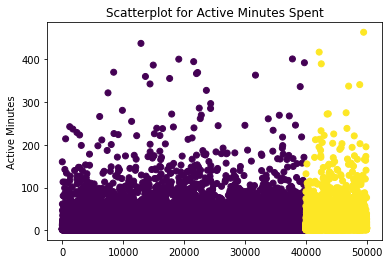

In [537]:
# checking scatter plot for active minutes -- seems like outliers are well-removed 

plt.scatter(dt.uid,dt.active_mins, c=dt.variant_number)  # color-coded by control and treatment 
plt.title("Scatterplot for Active Minutes Spent")
plt.ylabel("Active Minutes")
plt.show()

In [538]:
# Build regression to check treatment effect

import statsmodels.formula.api as smf

smf.ols("active_mins ~ variant_number", dt).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            active_mins   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     164.9
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           1.10e-37
Time:                        20:03:34   Log-Likelihood:            -2.0411e+05
No. Observations:               46633   AIC:                         4.082e+05
Df Residuals:                   46631   BIC:                         4.082e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.7613      0.100     87.997      0.000       8.566       8.956
variant_number     2.8774      0.224     12.842      0.000       2.438       3.317
==============================================================================
Omnibus:                    64105.673   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19951513.613
Skew:                           7.988   Prob(JB):                         0.00
Kurtosis:                     103.065   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [539]:
#computing mean value for treatment and control 
ctr_mean = dt.loc[dt['variant_number']==0].mean()
treat_mean = dt.loc[dt['variant_number']==1].mean()

print(f"Average active minutes per day for control group is {ctr_mean['active_mins'].round(decimals=2)}")
print(f"Average active minutes per day for treatment group is {treat_mean['active_mins'].round(decimals=2)}")
print("\n")
print(f"Percentage change from treatment to control group for active minutes per day is {(treat_mean['active_mins']-ctr_mean['active_mins'])/ctr_mean['active_mins']*100:.2f}%")

Average active minutes per day for control group is 8.76
Average active minutes per day for treatment group is 11.64


Percentage change from treatment to control group for active minutes per day is 32.84%


In [540]:
#computing p-value of difference in means 
pvalue = ttest_ind(dt.loc[dt['variant_number']==0, "active_mins"].values, dt.loc[dt['variant_number']==1, "active_mins"].values).pvalue

# P-value is not statistically significant at 0.05 level 
print(f"P-value of difference is {pvalue:.3f}")

P-value of difference is 0.000


## III. Pre/Post-experiment Analysis

In [541]:
# Concatenate t1 and t3 and join with t2 
t5 = pd.concat([t1_post_exp, t3_pre_exp])

# Join the data with t2 
new = pd.merge(t5, t2_exp_assignment, on='uid', how="left")
new.rename(columns={'dt_x': 'visit_date', 'dt_y': 'experiment_start'}, inplace=True)
new.head()

,uid,visit_date,active_mins,variant_number,experiment_start,signup_date
0,0,2019-02-22,5.0,0,2019-02-06,2018-09-24
1,0,2019-03-11,5.0,0,2019-02-06,2018-09-24
2,0,2019-03-18,3.0,0,2019-02-06,2018-09-24
3,0,2019-03-22,4.0,0,2019-02-06,2018-09-24
4,0,2019-04-03,9.0,0,2019-02-06,2018-09-24


In [542]:
# Checking how many treatment / control users we have 
new.variant_number.value_counts()

0    1876143
1     380014
Name: variant_number, dtype: int64

In [543]:
# Adding a variable to indicate post-treatment and pre-treatment 
new ["post_exp"] = (new.visit_date >= '2019-02-06').astype("int")

new.post_exp.value_counts()

0    1189927
1    1066230
Name: post_exp, dtype: int64

In [544]:
new['month'] = pd.DatetimeIndex(new['visit_date']).month

In [545]:
# Containters for plotting 
ctr_before = []
tr_before = []
ctr_after = []
tr_after = []

# X-axis
mon = [8,9,10,11,12,1,2]
mon1 = [2,3,4,5,6,7]

for x in mon:
    a = new[(new['variant_number']==0) & (new["post_exp"]==0) 
                  & (new['month']==x)]["active_mins"].mean()
    ctr_before.append(a)
    
for y in mon:
    b = new[(new['variant_number']==1) & (new["post_exp"]==0) 
                  & (new['month']==y)]["active_mins"].mean()
    tr_before.append(b)
    
    
for x in mon1:
    c = new[(new['variant_number']==0) & (new["post_exp"]==1) 
                  & (new['month']==x)]["active_mins"].mean()
    ctr_after.append(c)
    
for y in mon1:
    d = new[(new['variant_number']==1) & (new["post_exp"]==1) 
                  & (new['month']==y)]["active_mins"].mean()
    tr_after.append(d)

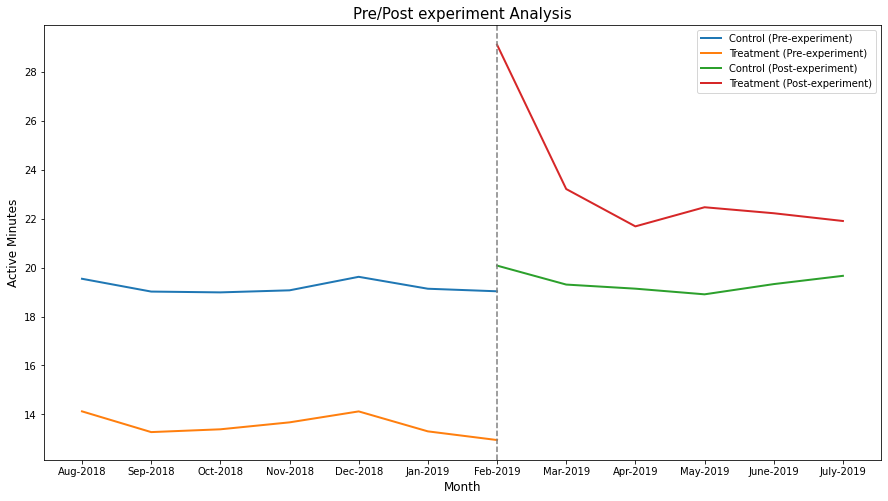

In [546]:
plt.figure(figsize=(15,8))

# x-axis 
month = ["Aug-2018", "Sep-2018", "Oct-2018", "Nov-2018", "Dec-2018", "Jan-2019", "Feb-2019"]
month1 = ["Feb-2019","Mar-2019", "Apr-2019","May-2019","June-2019","July-2019"]

# Plotting control and treatment graphs 
plt.plot(month, ctr_before , label="Control (Pre-experiment)", lw=2)
plt.plot(month, tr_before , label="Treatment (Pre-experiment)", lw=2)
plt.plot(month1, ctr_after , label="Control (Post-experiment)", lw=2)
plt.plot(month1, tr_after , label="Treatment (Post-experiment)", lw=2)

# Set title and lable
plt.title("Pre/Post experiment Analysis", fontsize="15")
plt.ylabel("Active Minutes", fontsize="12")
plt.xlabel("Month", fontsize="12")
plt.axvline(x="Feb-2019", c="grey", linestyle='--')
plt.legend();

In [547]:
# Treatment group: post-experiment and pre-expriment 
pvalue = ttest_ind(new.loc[(new['variant_number']==1)&(new['post_exp']==0), "active_mins"].values, new.loc[(new['variant_number']==1)&(new['post_exp']==1), "active_mins"].values).pvalue

# P-value is not statistically significant at 0.05 level 
print(f"P-value of difference for treatment group is {pvalue:.3f}")

P-value of difference for treatment group is 0.000


In [548]:
# Treatment group: post-experiment and pre-expriment 
pvalue = ttest_ind(new.loc[(new['variant_number']==0)&(new['post_exp']==0), "active_mins"].values, new.loc[(new['variant_number']==0)&(new['post_exp']==1), "active_mins"].values).pvalue

# P-value is not statistically significant at 0.05 level 
print(f"P-value of difference for control group is {pvalue:.3f}")

P-value of difference for control group is 0.043


- The graph above shows monthly active minutes for treatment and control group. Here we see that the active minutes for users have significantly increased for the treatment group (p-value < 0.05) whereas the control group remained relatively similar (p-value > 0.05). However, the treatment effect seems to fade out after a few months. 

## IV. Checking balance in user demographics
- As a result of t-testing, the difference in means for gender (unknown, male, female) and user type (reader, non-reader, contributor, new user) was all significant. Due to the imbalance between control and treatment group, we cannot trust the causal effect of the treatment since we do not know whether the increase in active minutes is due to the treatment or the imbalance. 

In [549]:
# Join new table with t4

df = pd.merge(new, t4_user_data, on='uid', how="left")

In [552]:
# function to test whether the difference in mean is significant

def ttest(x,y):
    print(ttest_ind(
    df.loc[(df["variant_number"] == 1)&(df["post_exp"]==1)&(df[x]==y), "active_mins"].values,
    df.loc[(df["variant_number"] == 0)&(df["post_exp"]==1)&(df[x]==y), "active_mins"].values))

In [554]:
# unknown - significant
ttest("gender", 'unknown')

Ttest_indResult(statistic=21.496301182271647, pvalue=2.482076404599259e-102)


In [555]:
# male- significant
ttest("gender", 'male')

Ttest_indResult(statistic=23.44143581961731, pvalue=1.8117134744982607e-121)


In [556]:
# female - significant
ttest("gender", 'female')

Ttest_indResult(statistic=19.40525473501602, pvalue=7.973486613090675e-84)


In [573]:
# Average active minutes for female users in control group is 16.87 minutes vs. Treatment 21.07 minutes

print(df.loc[(df["variant_number"] == 1)&(df["post_exp"]==1)&(df["gender"]=='female'), "active_mins"].mean(),
df.loc[(df["variant_number"] == 0)&(df["post_exp"]==1)&(df["gender"]=='female'), "active_mins"].mean())

21.07046857142857 16.877489474377434


In [558]:
# significant
ttest("user_type",'non_reader')

Ttest_indResult(statistic=77.98231511465234, pvalue=0.0)


In [560]:
# significant
ttest("user_type",'reader')

Ttest_indResult(statistic=53.993556565168966, pvalue=0.0)


In [562]:
# significant
ttest("user_type",'new_user')

Ttest_indResult(statistic=14.35833581334608, pvalue=1.7432201398801843e-46)


In [574]:
# 73.22% increase
print(
    df.loc[(df["variant_number"] == 1)&(df["post_exp"]==1)&(df["user_type"]=='new_user'), "active_mins"].mean(),
df.loc[(df["variant_number"] == 0)&(df["post_exp"]==1)&(df["user_type"]=='new_user'), "active_mins"].mean()
)

9.25145945945946 5.337986198243413


In [575]:
# difference in means are significant for contributor
ttest("user_type",'contributor')

Ttest_indResult(statistic=16.882781576409805, pvalue=8.190951804203081e-64)


In [576]:
# treatment group - contributor spent 88.38 minutes per day vs. control group contributor spent 65.87 minutes per day
# 34.17% increase
print(
    df.loc[(df["variant_number"] == 1)&(df["post_exp"]==1)&(df["user_type"]=='contributor'), "active_mins"].mean(),
df.loc[(df["variant_number"] == 0)&(df["post_exp"]==1)&(df["user_type"]=='contributor'), "active_mins"].mean()
)

88.38433111603844 65.87463507935975


In [577]:
# control group

ctr_pre_f = df.query("gender=='female' & variant_number == 0")
ctr_pre_f=ctr_pre_f.groupby(['gender','visit_date'],as_index=False).active_mins.mean()

ctr_pre_m = df.query("gender=='male' & variant_number == 0")
ctr_pre_m=ctr_pre_m.groupby(['gender','visit_date'],as_index=False).active_mins.mean()

ctr_pre_u = df.query("gender=='unknown'& variant_number == 0")
ctr_pre_u=ctr_pre_u.groupby(['gender','visit_date'],as_index=False).active_mins.mean()

# treatment group
tr_pre_f = df.query("gender=='female' & variant_number == 1")
tr_pre_f=tr_pre_f.groupby(['gender','visit_date'],as_index=False).active_mins.mean()

tr_pre_m = df.query("gender=='male' & variant_number == 1")
tr_pre_m=tr_pre_m.groupby(['gender','visit_date'],as_index=False).active_mins.mean()

tr_pre_u = df.query("gender=='unknown'& variant_number == 1")
tr_pre_u=tr_pre_u.groupby(['gender','visit_date'],as_index=False).active_mins.mean()

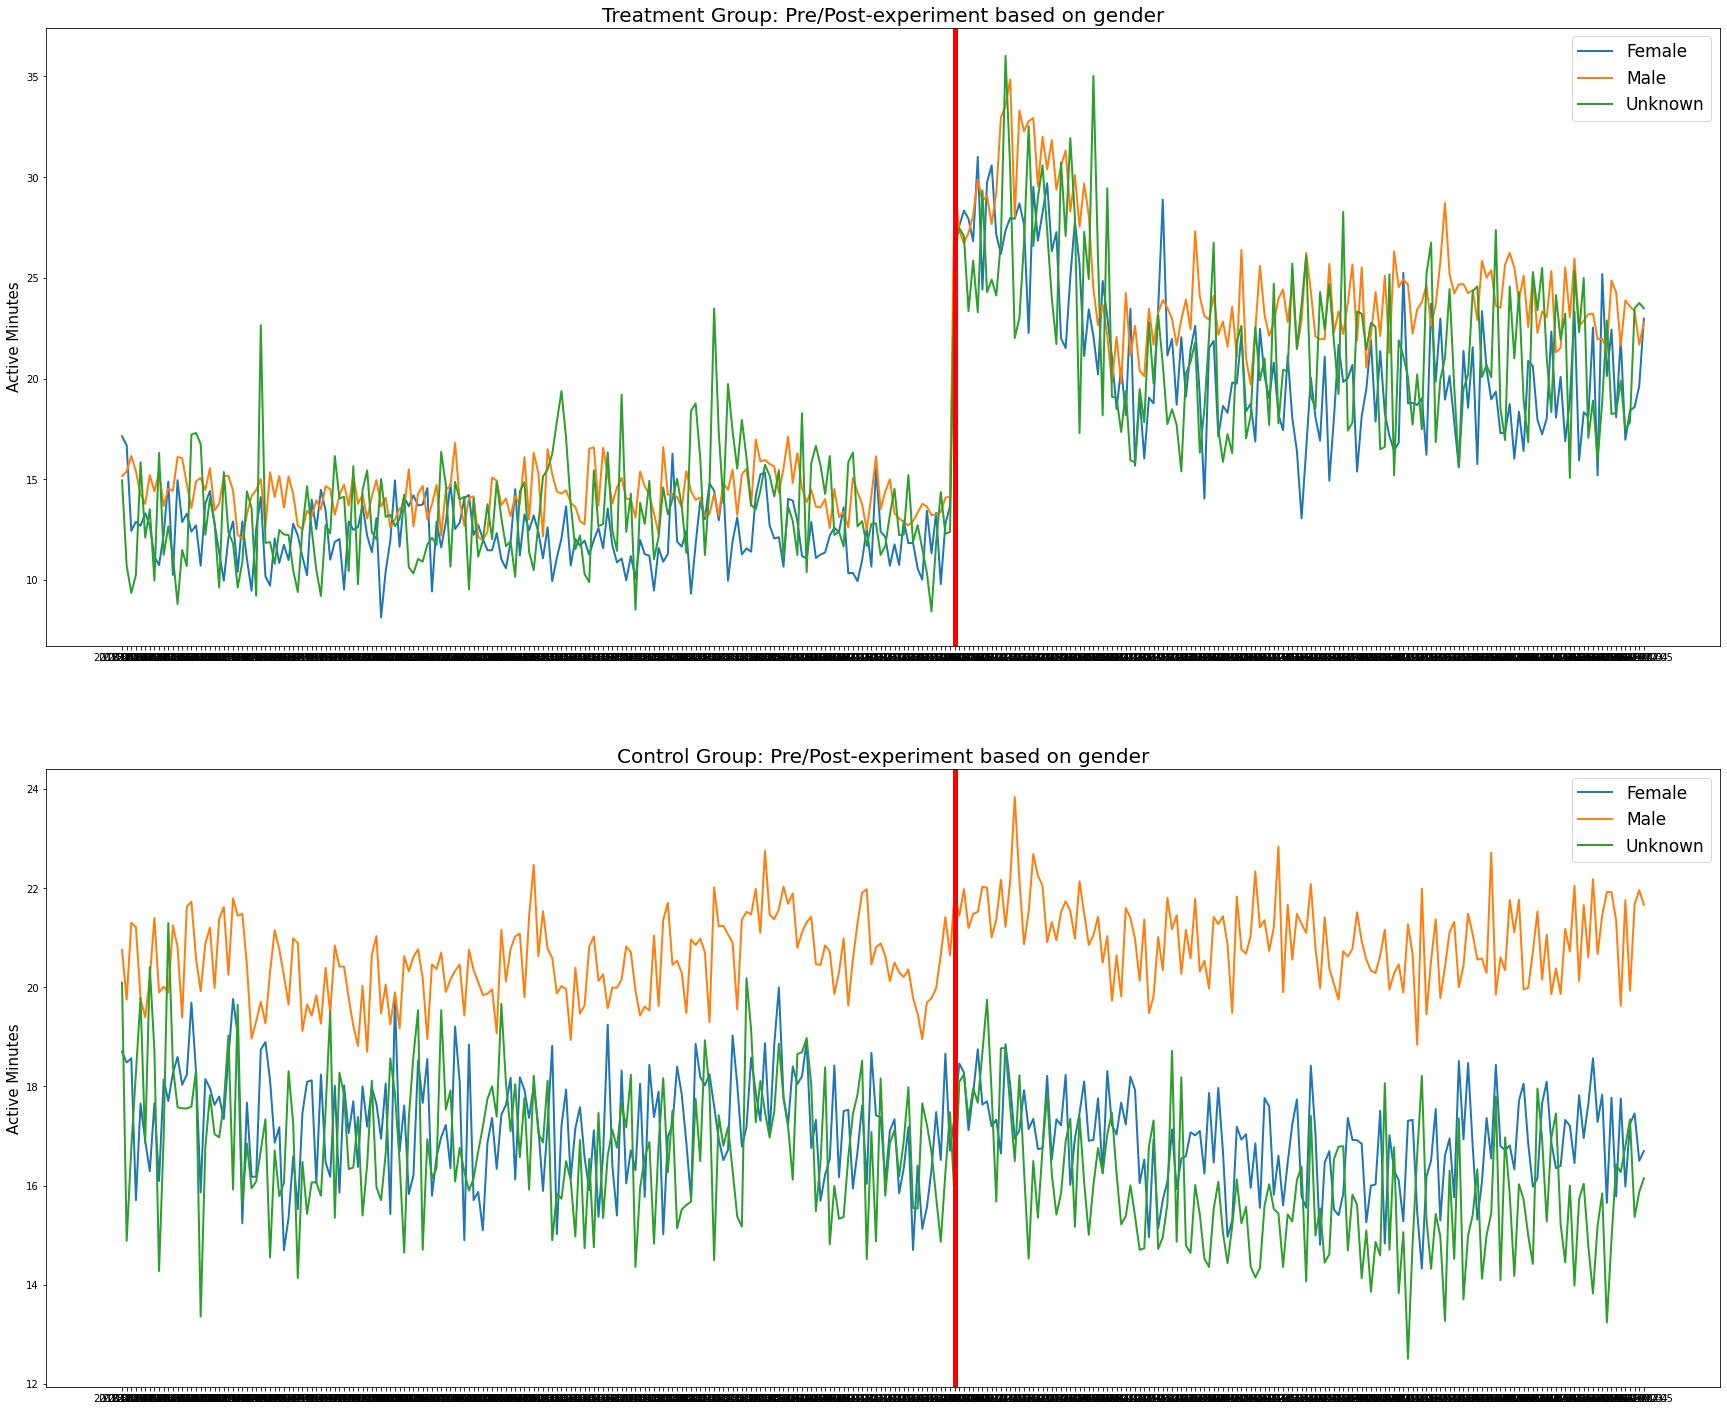

In [569]:
# Plotting based on different gender

plt.figure(figsize=(30,25))

plt.subplot(2,1,1)
plt.plot(tr_pre_f.visit_date, tr_pre_f.active_mins , label="Female", lw=2)
plt.plot(tr_pre_m.visit_date, tr_pre_m.active_mins , label="Male", lw=2)
plt.plot(tr_pre_u.visit_date, tr_pre_u.active_mins , label="Unknown", lw=2)
plt.axvline(x =df['experiment_start'].max(), color = 'red', lw=5)
plt.title("Treatment Group: Pre/Post-experiment based on gender", fontsize=20)
plt.ylabel("Active Minutes", fontsize=15)
plt.legend(fontsize=17)

plt.subplot(2,1,2)
plt.plot(ctr_pre_f.visit_date, ctr_pre_f.active_mins , label="Female", lw=2)
plt.plot(ctr_pre_m.visit_date, ctr_pre_m.active_mins , label="Male", lw=2)
plt.plot(ctr_pre_m.visit_date, ctr_pre_u.active_mins , label="Unknown", lw=2)
plt.axvline(x =df['experiment_start'].max(), color = 'red', lw=5)
plt.title("Control Group: Pre/Post-experiment based on gender", fontsize=20)
plt.ylabel("Active Minutes", fontsize=15)
plt.legend(fontsize = 17)
plt.show()

In [578]:
# control group
ctr_reader = df.query("user_type=='reader' & variant_number == 0").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()
ctr_nonreader = df.query("user_type=='non_reader' & variant_number == 0").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()
ctr_contributor = df.query("user_type=='contributor'& variant_number == 0").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()
ctr_newuser = df.query("user_type=='new_user'& variant_number == 0").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()

# treatment group
tr_reader = df.query("user_type=='reader' & variant_number == 1").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()
tr_nonreader = df.query("user_type=='non_reader' & variant_number == 1").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()
tr_contributor = df.query("user_type=='contributor'& variant_number == 1").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()
tr_newuser = df.query("user_type=='new_user'& variant_number == 1").groupby(['user_type','visit_date'],as_index=False).active_mins.mean()

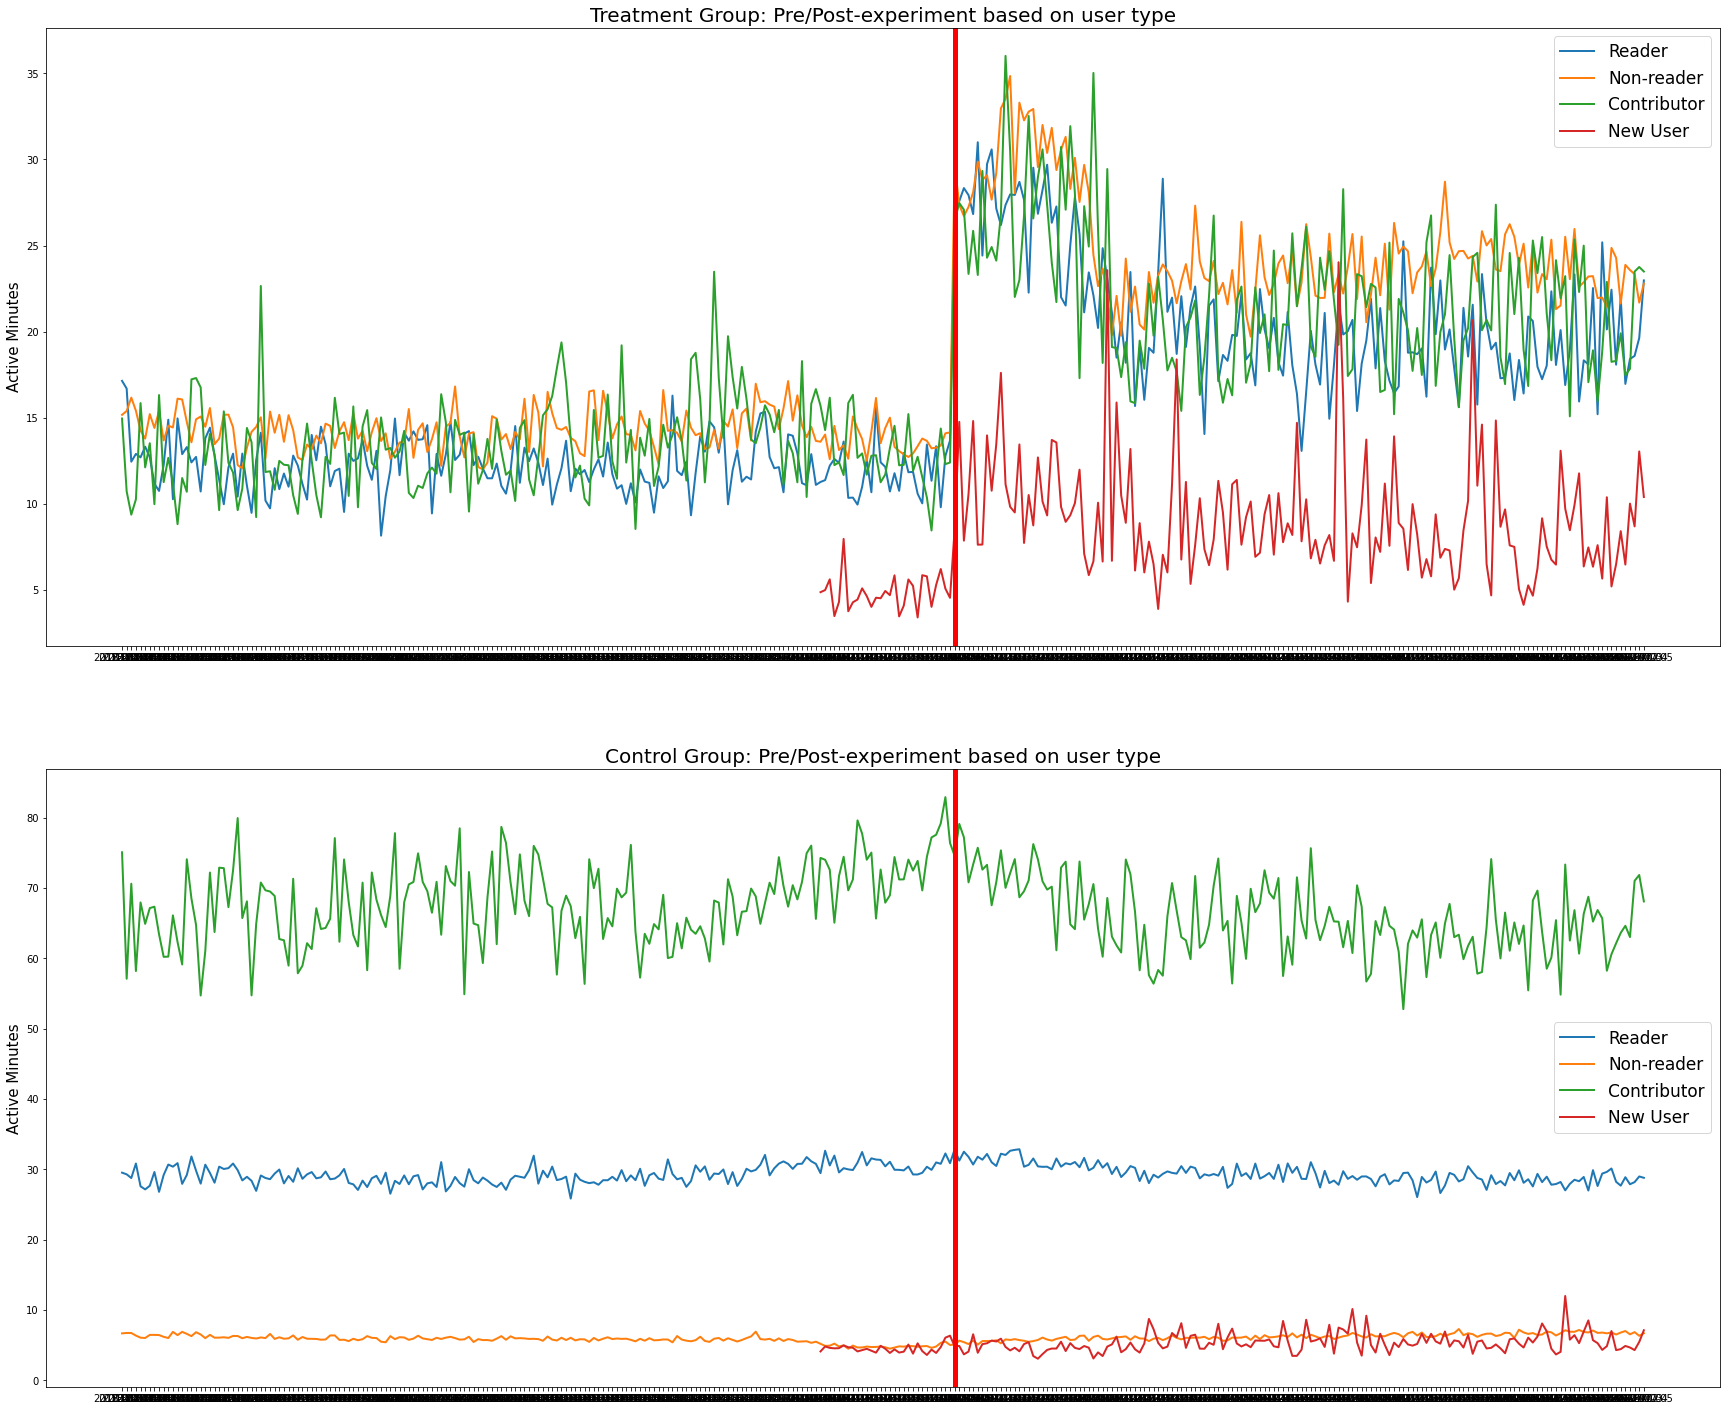

In [579]:
# Plotting based on different user_type 

plt.figure(figsize=(30,25))

plt.subplot(2,1,1)
plt.plot(tr_reader.visit_date, tr_pre_f.active_mins , label="Reader", lw=2)
plt.plot(tr_nonreader.visit_date, tr_pre_m.active_mins , label="Non-reader", lw=2)
plt.plot(tr_contributor.visit_date, tr_pre_u.active_mins , label="Contributor", lw=2)
plt.plot(tr_newuser.visit_date, tr_newuser.active_mins , label="New User", lw=2)
plt.axvline(x =df['experiment_start'].max(), color = 'red', lw=5)
plt.title("Treatment Group: Pre/Post-experiment based on user type", fontsize=20)
plt.ylabel("Active Minutes", fontsize=15)
plt.legend(fontsize=17)

plt.subplot(2,1,2)
plt.plot(ctr_reader.visit_date, ctr_reader.active_mins , label="Reader", lw=2)
plt.plot(ctr_nonreader.visit_date, ctr_nonreader.active_mins , label="Non-reader", lw=2)
plt.plot(ctr_contributor.visit_date, ctr_contributor.active_mins , label="Contributor", lw=2)
plt.plot(ctr_newuser.visit_date, ctr_newuser.active_mins , label="New User", lw=2)
plt.axvline(x =df['experiment_start'].max(), color = 'red', lw=5)
plt.title("Control Group: Pre/Post-experiment based on user type", fontsize=20)
plt.ylabel("Active Minutes", fontsize=15)
plt.legend(fontsize = 17)
plt.show()

## V. Matching
- Since there was imbalance in treatment and control group assignment, I adopted matching to control for the imbalance. As a result of running a regression on matched data, the treatment effect was statistically significant and treatment grup spent +2.68 minutes compared to the control group. Therefore, implementing the new UI makes sense. 

In [580]:
matching = df.copy()

In [581]:
# Convert string variables to categorical variable
# male 1, female 0, unknown 2 

matching["gender"] = pd.Categorical(matching["gender"]).codes

In [582]:
#non_reader 2, reader 3, contributor 0, new_user 1

matching["user_type"] = pd.Categorical(matching["user_type"]).codes
matching["user_type"].value_counts()

2    1231494
3     861170
0     140160
1      23333
Name: user_type, dtype: int64

In [584]:
# drop columns not related to matching

for_matching = matching.drop(["experiment_start", "signup_date", "visit_date"], axis="columns")
for_matching = for_matching[for_matching.active_mins.notnull()] #taking non-null values of response variable
for_matching = for_matching[for_matching["post_exp"]==1] #taking only the post-experiment data 
for_matching = for_matching.drop(["post_exp"], axis="columns")
for_matching = for_matching.reset_index(drop=True) # reset index
for_matching

,uid,active_mins,variant_number,month,gender,user_type
0,0,5.0,0,2,1,2
1,0,5.0,0,3,1,2
2,0,3.0,0,3,1,2
3,0,4.0,0,3,1,2
4,0,9.0,0,4,1,2
...,...,...,...,...,...,...
1066225,49999,24.0,1,4,0,2
1066226,49999,1.0,1,4,0,2
1066227,49999,6.0,1,5,0,2
1066228,49999,2.0,1,6,0,2


In [585]:
for_matching = for_matching.groupby(['uid']).agg({'active_mins':'mean', 'variant_number':'mean', 'gender':'mean', 'user_type':'mean'})
for_matching = for_matching.reset_index(drop=True) # reset index

In [586]:
import dame_flame

model = dame_flame.matching.DAME(repeats=False, verbose=3, want_pe=True)
model.fit(
    for_matching,
    treatment_column_name="variant_number",
    outcome_column_name="active_mins",
)
result = model.predict(for_matching)

Iteration number:  1
	Number of matched groups formed in total:  12
	Unmatched treated units:  0 out of a total of  9208 treated units
	Unmatched control units:  0 out of a total of  37425 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  46633
	Number of matches made so far:  46633
	In this iteration, the covariates dropped are:  set()
46633 units matched. We finished with no more treated units to match


In [587]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. 
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [588]:
matched_data = get_dataframe(model, result)
matched_data.head()

,active_mins,variant_number,gender,user_type,match_group,match_group_size,weights
0,3.307692,0,1,2,7.0,19115.0,1.051226
1,160.052632,0,1,3,10.0,4844.0,0.744578
2,2.428571,0,1,2,7.0,19115.0,1.051226
3,3.208333,0,1,2,7.0,19115.0,1.051226
4,1.950000,0,1,2,7.0,19115.0,1.051226


In [589]:
# Running regression on matched data 
# Intercept 41mins
# Treatment group spent + 2.68 minutes on average compared to control group (p-value significant)
# Therefore, implement the new UI 

smf.wls(
    "active_mins ~ C(variant_number) + C(gender)"
    " + C(user_type)",
    matched_data,
    weights=matched_data["weights"],
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            active_mins   R-squared:                       0.270
Model:                            WLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     2872.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        21:20:42   Log-Likelihood:            -1.9164e+05
No. Observations:               46633   AIC:                         3.833e+05
Df Residuals:                   46626   BIC:                         3.834e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 54.6873      0.591     92.485      0.000      53.528      55.846
C(variant_number)[T.1]     4.1558      0.171     24.370      0.000       3.822       4.490
C(gender)[T.1]             0.8795      0.157      5.609      0.000       0.572       1.187
C(gender)[T.2]             0.3935      0.213      1.848      0.065      -0.024       0.811
C(user_type)[T.1]        -52.0275      0.622    -83.606      0.000     -53.247     -50.808
C(user_type)[T.2]        -51.0101      0.583    -87.441      0.000     -52.154     -49.867
C(user_type)[T.3]        -31.7279      0.607    -52.311      0.000     -32.917     -30.539
==============================================================================
Omnibus:                    64128.323   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28096835.470
Skew:                           7.829   Prob(JB):                         0.00
Kurtosis:                     122.227   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## VI. Ideas for User Retention

Users can be segmented into signup users who are new to the service and experienced users who have either read, wrote or contributed to the service. The data analysis and key metrics for each subgroup should be different.

1. Signup User

For signup user, we can look at two key metrics: 7-day retention rate and number of days it took for signup users to write their first post.

1-1. 7-day retention rate 
= Number of users revisited within 7 days / number of users who signed up for the first time * 100

Compared to 30-day or 14-day retention rate, 7-day retention rate directly reflects whether the signup user got a positive impression of the service or not. If the data shows that 7-day retention rate for sign up users decrease over few months, this may indicate that signup users are having difficulties engaging with the new platform. This difficulty may imply that either (i) they haven't developed a habit of logging in to the platform regularly or (ii) they could not find interesting spaces or build feeds. 
As such, we can consider sending push messages or emails with trending posts to help them develop the habit of using the service. When sending alerts to new users, we can optimize the process by identifying key features that can predict whether a signup user would revisit the service after receiving the alert. Another way is to tune the space recommendation system so that signup users can quickly construct a feed that would interest them. 

1.2 Number of days it took for signup user to write their first post 
= Date when a signup user first wrote a post – date when they first signed up

As seen in the data, writing posts is a more proactive and engaging experience for the users compared to reading and searching for answers, and thus we can assume that they are more likely to remain as an active user. If the number of days it took for signup users to write a post increase, it can be an indicator that signup users are having difficulties participating in spaces. As such, we can consider running an incentive program for the new users to write their first post. The effectiveness of the incentive program can be verified through experimenting on the users who participated in the program and users who did not participate and comparing the number of days it took for each group to upload their first post. 

2. Experienced User

2.1 Revisit period 
= Days (hours) between the time of users’ last login and second-last login

Using ‘user_type’ data, we can breakdown users into non-reader, reader and contributor and further breakdown by the number of clicks for reader group (or posts written for contributor and non-reader group). For example, we can breakdown readers’ number of clicks in the past one year into 4-5 categories based on the number of clicks distribution and then track how many days it took for each user segment to revisit the app. If certain segment shows increased hours of revisit period, I would suggest doing a root cause analysis. Some hypothesis on the increased hours are: (i) the spaces that experience users mainly follow have become less active and experienced users are seeing the same content every time they log in, (ii) track down when the revisit hours started to increase and check if it's related to recent app release or platform difference. 